# Combine and process Cleanalyze results

Author: **Niels J. de Winter** (*n.j.de.winter@vu.nl*)<br>
Assistant Professor Vrije Universiteit Amsterdam

## Load packages

In [85]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import re
from sklearn.linear_model import LinearRegression
from scipy.stats import t
from collections import OrderedDict

## Read all cleanalyze data

In [86]:
folder_path = "Cleanalyze_results"
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')] # List all CSV files in the folder
dataframes = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)
    dataframes[file] = df

# Print the first few rows of each DataFrame
for file, df in dataframes.items():
    print(f"Data from {file}:")
    print(df.head(), "\n")  # Display the first few rows of each DataFrame
    print(f"Shape: {df.shape}\n")  # Print the shape of the DataFrame
    print(f"Columns: {df.columns.tolist()}\n")  # Print the column names
    print("-" * 40)  # Separator for clarity

Data from B255_peakid.csv:
      depth  proxy_filtered      time         Xpos         Ypos         Ca43  \
0  0.445779        0.013676  62.33211  30944.10620  80703.27530  6301.588000   
1  0.891558        0.000000  62.44125  30944.46978  80703.01737  5301.123838   
2  1.337336        0.019326  62.55040  30944.83337  80702.75945  4600.846556   
3  1.783115        0.037763  62.65955  30945.19695  80702.50152  5751.322804   
4  2.228894        0.013795  62.76871  30945.56053  80702.24359  6251.562891   

    23Na/43Ca  25Mg/43Ca  43Ca/43Ca  55Mn/43Ca  88Sr/43Ca  138Ba/43Ca  \
0  199.059248   1.253571       1000   0.306491   0.013676         0.0   
1  235.482235   3.406310       1000   0.347474   0.000000         0.0   
2  284.331679   1.771388       1000   0.380053   0.019326         0.0   
3  221.307763   3.115197       1000   0.348871   0.037763         0.0   
4  205.558351   1.264443       1000   0.242893   0.013795         0.0   

         peak  
0  interval 0  
1  interval 0  
2  in

### Plot locations of intervals in each specimen

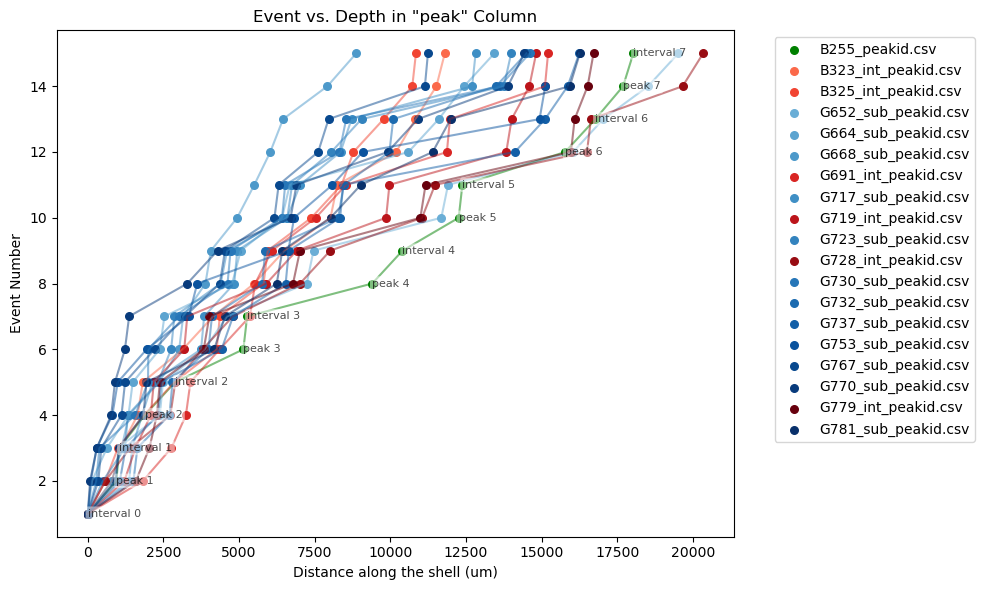

In [87]:
plt.figure(figsize=(10, 6))

# Prepare color maps for treatments
subtidal_files = [f for f in dataframes if 'sub' in f.lower()]
intertidal_files = [f for f in dataframes if 'int' in f.lower()]
other_files = [f for f in dataframes if f not in subtidal_files + intertidal_files]

subtidal_colors = cm.Blues(np.linspace(0.5, 1, len(subtidal_files)))
intertidal_colors = cm.Reds(np.linspace(0.5, 1, len(intertidal_files)))

sub_idx = 0
int_idx = 0

for file, df in dataframes.items():
    if 'depth' in df.columns and 'peak' in df.columns:
        transitions = df['peak'] != df['peak'].shift()
        transition_depths = df.loc[transitions, 'depth'].reset_index(drop=True)
        if file in subtidal_files:
            color = subtidal_colors[sub_idx]
            sub_idx += 1
        elif file in intertidal_files:
            color = intertidal_colors[int_idx]
            int_idx += 1
        else:
            color = 'green'
        scatter = plt.scatter(transition_depths, range(1, len(transition_depths) + 1), label=file, s=30, color=color)
        plt.plot(transition_depths, range(1, len(transition_depths) + 1), linestyle='-', alpha=0.5, color=color)

# After the for loop, add interval labels inside the plotting area, one per interval
ref_file = next((f for f, df in dataframes.items() if 'depth' in df.columns and 'peak' in df.columns), None)
if ref_file:
    ref_df = dataframes[ref_file]
    transitions = ref_df['peak'] != ref_df['peak'].shift()
    transition_depths = ref_df.loc[transitions, 'depth'].reset_index(drop=True)
    peak_labels = ref_df.loc[transitions, 'peak'].reset_index(drop=True)
    for y, label in enumerate(peak_labels, start=1):
        plt.text(
            transition_depths.iloc[y-1], y, str(label),
            va='center', ha='left', fontsize=8, color='black', alpha=0.7,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, boxstyle='round,pad=0.2')
        )

plt.xlabel('Distance along the shell (um)')
plt.ylabel('Event Number')
plt.title('Event vs. Depth in "peak" Column')
plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

## Load information about the timing of the peaks and the beginning and end of the experiment

### Timing of the Sr peaks and start and end of experiment

In [88]:
timing_sr_spikes = pd.read_csv("Timing_Sr_spikes.csv") # Load the CSV file containing timing data
# Convert 'Start' and 'End' columns to datetime, specifying the format to include both date and time
timing_sr_spikes['Start'] = pd.to_datetime(timing_sr_spikes['Start'], format='%d-%m-%Y%H:%M')
timing_sr_spikes['End'] = pd.to_datetime(timing_sr_spikes['End'], format='%d-%m-%Y%H:%M')

# Reverse the order of the "Number" column without sorting the other columns
max_number = timing_sr_spikes['Number'].max()
min_number = timing_sr_spikes['Number'].min()
timing_sr_spikes['Number'] = max_number - (timing_sr_spikes['Number'] - min_number)

# Duplicate rows where 'Containers' == 'All' for both 'Subtidal' and 'Intertidal'
all_rows = timing_sr_spikes[timing_sr_spikes['Containers'] == 'All']
if not all_rows.empty:
    subtidal_rows = all_rows.copy()
    subtidal_rows['Containers'] = 'Subtidal'
    intertidal_rows = all_rows.copy()
    intertidal_rows['Containers'] = 'Intertidal'
    # Append the new rows to the dataframe
    timing_sr_spikes = pd.concat([timing_sr_spikes, subtidal_rows, intertidal_rows], ignore_index=True)
    timing_sr_spikes = timing_sr_spikes[timing_sr_spikes['Containers'] != 'All'].reset_index(drop=True)

# Add rows for the start and end of the experiment
start_row = timing_sr_spikes.iloc[0].copy()
start_row['Start'] = pd.to_datetime("01-02-202210:00", format='%d-%m-%Y%H:%M') # Add start date and time (February 1, 2022, 10:00 AM)
start_row['End'] = pd.to_datetime("01-02-202210:00", format='%d-%m-%Y%H:%M')
start_row['Number'] = 0
start_row['level'] = None
end_row = timing_sr_spikes.iloc[-1].copy()
end_row['Start'] = pd.to_datetime("25-10-202210:00", format='%d-%m-%Y%H:%M') # Add end date and time (October 25, 2022, 10:00 AM)
end_row['End'] = pd.to_datetime("25-10-202210:00", format='%d-%m-%Y%H:%M')
end_row['Number'] = timing_sr_spikes['Number'].max() + 1
end_row['level'] = None
# Add start and end rows for both 'Subtidal' and 'Intertidal'
for container in ['Subtidal', 'Intertidal']:
    start_row_mod = start_row.copy()
    start_row_mod['Containers'] = container
    end_row_mod = end_row.copy()
    end_row_mod['Containers'] = container
    timing_sr_spikes = pd.concat([timing_sr_spikes, start_row_mod.to_frame().T, end_row_mod.to_frame().T], ignore_index=True)

print(timing_sr_spikes.head())

  Number  Containers                Start                  End level
0      6  Intertidal  2022-05-11 10:40:00  2022-05-12 10:50:00   low
1      6    Subtidal  2022-05-11 11:00:00  2022-05-12 11:10:00   low
2      5  Intertidal  2022-05-31 15:00:00  2022-06-01 15:00:00  High
3      5    Subtidal  2022-05-31 15:30:00  2022-06-01 15:30:00  High
4      4  Intertidal  2022-06-27 13:30:00  2022-06-28 12:45:00   Low


## Load information about the timing and data on caliper measurements

In [89]:
# Open the sheet containing caliper measurements
caliper_file = "Caliper measurements cockles 2022.xlsx"
caliper_data = {"Caliper measurements": pd.read_excel(caliper_file, sheet_name="Caliper measurements")}
# print(caliper_data["Caliper measurements"].head())

# Extract the "Height" data for all specimens contained in the Sr spiking data
# Extract specimen names as the first letter and first three numbers from each file name
specimen_names = [re.match(r'([A-Z]\d{3})', name).group(1) if re.match(r'([A-Z]\d{3})', name) else name for name in dataframes.keys()]
print("Specimens in Sr spiking data:", specimen_names)
# Isolate columns containing "Height"
height_columns = [col for col in caliper_data["Caliper measurements"].columns if "Height" in col]

# Isolate rows with specimen names in "specimen_names"
# The specimen name is likely in the "ID" column
caliper_df = caliper_data["Caliper measurements"]
filtered_caliper_data = caliper_df[caliper_df["ID"].isin(specimen_names)][["ID"] + height_columns]

print(filtered_caliper_data)


Specimens in Sr spiking data: ['B255', 'B323', 'B325', 'G652', 'G664', 'G668', 'G691', 'G717', 'G719', 'G723', 'G728', 'G730', 'G732', 'G737', 'G753', 'G767', 'G770', 'G779', 'G781']
       ID  220119 Height  220301 Height  220424 Height  220601 Height  \
14   G753          10.58          10.89          14.92            NaN   
17   G767          12.00          12.29          15.00            NaN   
38   G781           9.49          10.18          14.40            NaN   
45   G770          15.62          15.72          17.92            NaN   
49   G730          12.21          12.26          15.99            NaN   
50   G664          17.93          18.39          20.27            NaN   
55   G737          11.12          11.67          15.83            NaN   
71   G732          13.57          13.77          17.00            NaN   
73   G717          14.25          14.65          16.74            NaN   
89   G652          16.19          16.40          18.63            NaN   
105  G719     

### Load information from 2020 experiment to link caliper measurements for cockles to distance along profile

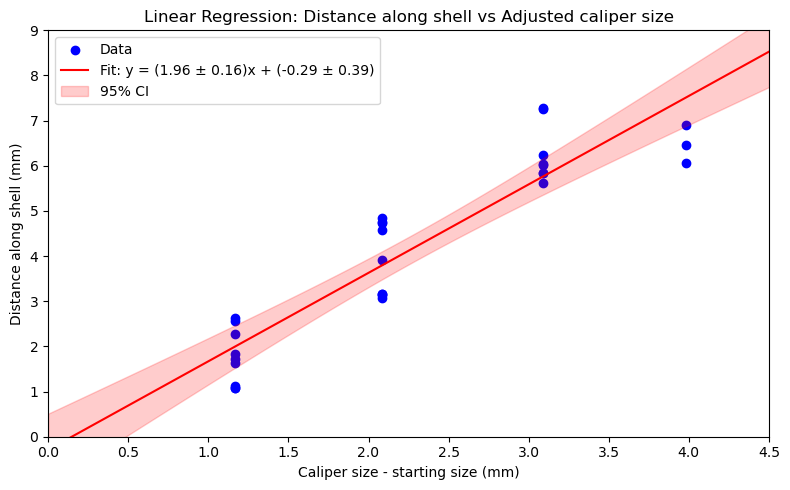

In [90]:
calibration_caliper_df = pd.read_csv("Calibration_caliper_measurements_2020.csv")

# Prepare data for linear regression
X = calibration_caliper_df['Adjusted caliper size'].values.reshape(-1, 1)
y = calibration_caliper_df['Peak_mm'].values

# Fit linear regression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

# Calculate residuals and standard error of regression
residuals = y - y_pred
n = len(y)
p = 2  # number of parameters (slope + intercept)
s_err = np.sqrt(np.sum(residuals**2) / (n - p))

# For error envelope: calculate 95% confidence interval for the regression line
X_flat = X.flatten()
mean_x = np.mean(X_flat)
t_val = t.ppf(0.975, n - p)  # two-tailed 95% CI

# Expand prediction to entire x-axis (0, 4.5)
x_range = np.linspace(0, 4.5, 200).reshape(-1, 1)
y_range_pred = reg.predict(x_range)

# Calculate confidence interval for the expanded range
mean_x = np.mean(X_flat)
conf_interval_range = t_val * s_err * np.sqrt(1/n + (x_range.flatten() - mean_x)**2 / np.sum((X_flat - mean_x)**2))
upper_range = y_range_pred + conf_interval_range
lower_range = y_range_pred - conf_interval_range

# Print regression formula with uncertainty
# Standard errors of slope and intercept
Sxx = np.sum((X_flat - mean_x)**2)
slope_se = s_err / np.sqrt(Sxx)
intercept_se = s_err * np.sqrt(1/n + mean_x**2 / Sxx)

# Add regression formula with uncertainty to the legend
regression_label = (
    f"Fit: y = ({reg.coef_[0]:.2f} ± {slope_se:.2f})x + ({reg.intercept_:.2f} ± {intercept_se:.2f})"
)

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(X, y, label='Data', color='blue')
plt.plot(x_range, y_range_pred, color='red', label=regression_label)
plt.fill_between(x_range.flatten(), lower_range, upper_range, color='red', alpha=0.2, label='95% CI')
plt.xlim(0, 4.5)
plt.ylim(0, 9)
plt.xlabel('Caliper size - starting size (mm)')
plt.ylabel('Distance along shell (mm)')
plt.title('Linear Regression: Distance along shell vs Adjusted caliper size')
plt.legend()
plt.tight_layout()
plt.show()

### Extract dates of shell height measurements from 2022 caliper measurements and convert to equivalent length along record

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


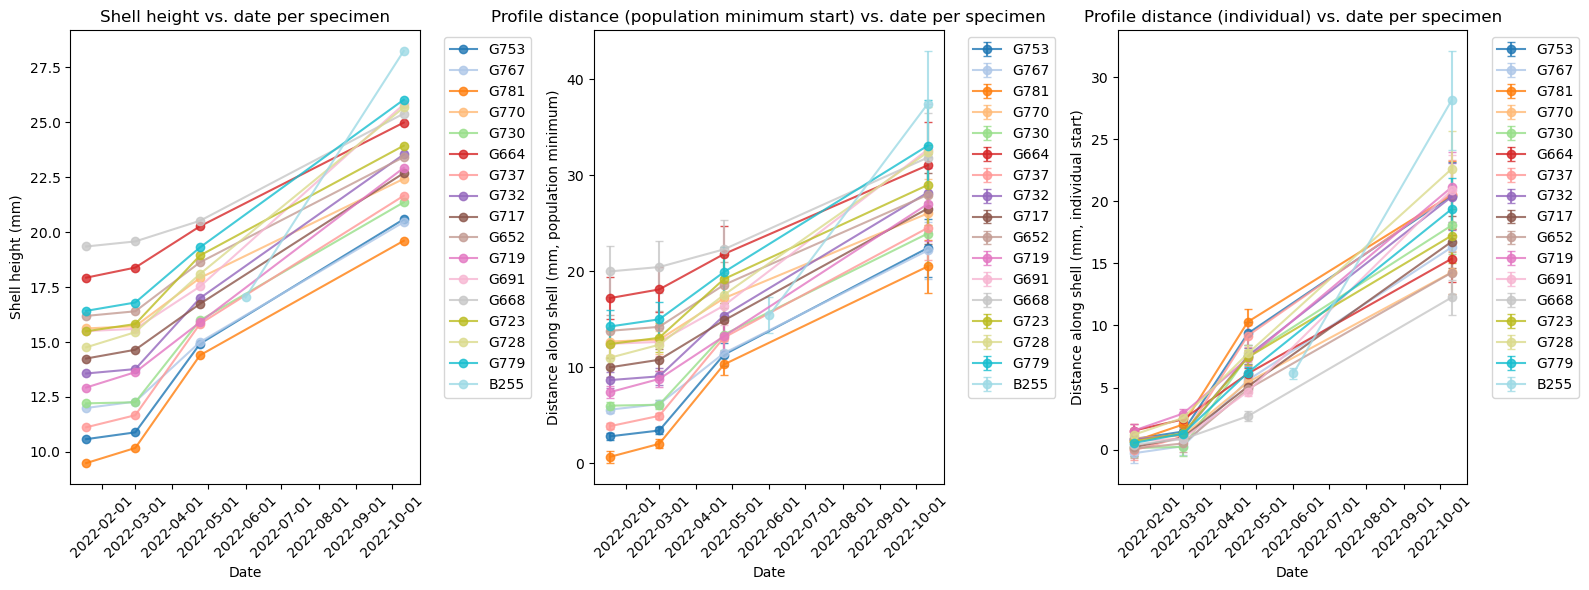

In [91]:
# --------------Extracting Caliper Measurements----------------
# Extract dates from the first 6 digits of the column names and parse as datetime
date_columns = [col for col in filtered_caliper_data.columns if any(char.isdigit() for char in col)]
date_mapping = {}

for col in date_columns:
    match = re.match(r'(\d{6})', col)
    if match:
        date_str = match.group(1)
        # Parse as datetime, assuming format is YYMMDD (e.g., 220101 for January 1, 2022)
        date = pd.to_datetime(date_str, format='%y%m%d')
        date_mapping[col] = date

# Melt the dataframe to long format: columns -> 'ID', 'date', 'shell_height'
caliper_long = filtered_caliper_data.melt(
    id_vars=['ID'],
    value_vars=date_columns,
    var_name='date_col',
    value_name='shell_height'
)

# Map the extracted dates to the 'date_col' column
caliper_long['date'] = caliper_long['date_col'].map(date_mapping)
caliper_long = caliper_long.dropna(subset=['date', 'shell_height'])

# Rename columns for clarity
caliper_long = caliper_long.rename(columns={'ID': 'specimen'})
caliper_long = caliper_long[['specimen', 'date', 'shell_height']]

# ----------------Calculating distance along shell----------------
# Find lowest shell height in dataset and round down to nearest mm
min_shell_height = caliper_long['shell_height'].min()
min_shell_height = np.floor(min_shell_height)

# Adjust shell heights to relative to the minimum shell height
caliper_long['adjusted_shell_height'] = caliper_long['shell_height'] - min_shell_height

# Calculate minimum shell height per specimen (floored)
min_shell_height_per_specimen = caliper_long.groupby('specimen')['shell_height'].min().apply(np.floor)

# For specimen B255, set its minimum shell height to the mean minimum of the other specimens because the first measurement for this specimen is in May
other_specimens = min_shell_height_per_specimen.drop('B255')
mean_min_other = other_specimens.mean()
min_shell_height_per_specimen['B255'] = mean_min_other

# Map to each row and compute adjusted shell height per individual
caliper_long['adjusted_shell_height_individual'] = caliper_long.apply(
    lambda row: row['shell_height'] - min_shell_height_per_specimen[row['specimen']],
    axis=1
)

# Convert to equivalent distance along the shell and subtract starting point to compare with Sr spiking data
# Use the regression model to predict distance along shell (mm) from adjusted shell height
caliper_long['distance_mm'] = reg.predict(caliper_long[['adjusted_shell_height']])
caliper_long['distance_mm_individual'] = reg.predict(caliper_long[['adjusted_shell_height_individual']])

# Calculate 95% confidence interval for each prediction
# Formula: CI = t_val * s_err * sqrt(1/n + (x - mean_x)^2 / Sxx)
caliper_long['distance_mm_ci'] = t_val * s_err * np.sqrt(
    1 / n + (caliper_long['adjusted_shell_height'] - mean_x) ** 2 / Sxx
)
caliper_long['distance_mm_ci_individual'] = t_val * s_err * np.sqrt(
    1 / n + (caliper_long['adjusted_shell_height_individual'] - mean_x) ** 2 / Sxx
)

# --------------Plotting the Caliper Measurements----------------
# Plot the caliper measurements over time for each specimen
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6), sharey=False)
specimens = caliper_long['specimen'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(specimens)))

# Panel 1 (left): Shell height vs date
for i, specimen in enumerate(specimens):
    df_spec = caliper_long[caliper_long['specimen'] == specimen]
    ax1.plot(
        df_spec['date'],
        df_spec['shell_height'],
        'o-',
        label=specimen,
        color=colors[i],
        alpha=0.8
    )
ax1.set_xlabel('Date')
ax1.set_ylabel('Shell height (mm)')
ax1.set_title('Shell height vs. date per specimen')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Panel 2 (middle): Distance along shell (mm) vs date
for i, specimen in enumerate(specimens):
    df_spec = caliper_long[caliper_long['specimen'] == specimen]
    ax2.errorbar(
        df_spec['date'],
        df_spec['distance_mm'],
        yerr=df_spec['distance_mm_ci'],
        fmt='o-',
        label=specimen,
        color=colors[i],
        capsize=3,
        alpha=0.8
    )
ax2.set_xlabel('Date')
ax2.set_ylabel('Distance along shell (mm, population minimum)')
ax2.set_title('Profile distance (population minimum start) vs. date per specimen')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Panel 3 (right): Distance along shell (individual) vs date
for i, specimen in enumerate(specimens):
    df_spec = caliper_long[caliper_long['specimen'] == specimen]
    ax3.errorbar(
        df_spec['date'],
        df_spec['distance_mm_individual'],
        yerr=df_spec['distance_mm_ci_individual'],
        fmt='o-',
        label=specimen,
        color=colors[i],
        capsize=3,
        alpha=0.8
    )
ax3.set_xlabel('Date')
ax3.set_ylabel('Distance along shell (mm, individual start)')
ax3.set_title('Profile distance (individual) vs. date per specimen')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.setp(ax1.get_xticklabels(), rotation=45)
plt.setp(ax2.get_xticklabels(), rotation=45)
plt.setp(ax3.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## Link dates of spikes to peaks in profiles (create "age model")

In [92]:
# Loop through each DataFrame and add timing info based on the peak labels
for file, df in dataframes.items():
    # Create a new column for timing info
    df['timing_info'] = None
    # Create a new column for centered timing info, default None
    df['timing_info_centered'] = None
    # First assign timing to the peaks based on the 'peak' column
    # Map the timing info to the DataFrame based on the peak labels
    for i, row in df.iterrows(): # Iterate through each row in the DataFrame
        peak_label = row['peak'] # Get the peak label for the current row

        # Try to extract the peak number from the label (e.g., "peak 1" -> 1)
        if "peak" in peak_label:
            try:
                peak_num = int(peak_label.split()[-1])
            except Exception:
                peak_num = None
        else:
            peak_num = None

        # Find timing info for this peak number (if available)
        if peak_num is not None:
            # Find all rows with this peak label
            peak_rows = df[df['peak'] == peak_label]
            if not peak_rows.empty:
                # Find the middle row index for this peak
                middle_idx = peak_rows.index[len(peak_rows) // 2]
                # Find the start and end value for the correct treatment (subtidal vs intertidal)
                if file.endswith('_sub_peakid.csv'):
                    start_value = timing_sr_spikes.loc[
                        (timing_sr_spikes['Number'] == peak_num) & 
                        (timing_sr_spikes['Containers'].str.lower() == 'subtidal'), 'Start'
                    ]
                    end_value = timing_sr_spikes.loc[
                        (timing_sr_spikes['Number'] == peak_num) & 
                        (timing_sr_spikes['Containers'].str.lower() == 'subtidal'), 'End'
                    ]
                else:
                    start_value = timing_sr_spikes.loc[
                        (timing_sr_spikes['Number'] == peak_num) & 
                        (timing_sr_spikes['Containers'].str.lower() == 'intertidal'), 'Start'
                    ]
                    end_value = timing_sr_spikes.loc[
                        (timing_sr_spikes['Number'] == peak_num) & 
                        (timing_sr_spikes['Containers'].str.lower() == 'intertidal'), 'End'
                    ]

                start_value = start_value.iloc[0] if not start_value.empty else None
                end_value = end_value.iloc[0] if not end_value.empty else None
                # Average start and end values (as datetime) for this peak (single values)
                avg_time = start_value + (end_value - start_value) / 2
                # Only assign timing_info_centered for the middle row
                if i == middle_idx:
                    if start_value is not None and end_value is not None:
                        df.at[i, 'timing_info_centered'] = avg_time            
                # Add timing info to all rows in the peak               
                df.at[i, 'timing_info'] = avg_time # Assign the average time to the 'timing_info' column for this peak
    
    # Add the start and end times for the entire experiment
    # These will be used for linear interpolation of the intervals
    start_experiment = pd.to_datetime("01-02-202210:00", format='%d-%m-%Y%H:%M')  # Start date and time
    end_experiment = pd.to_datetime("25-10-202210:00", format='%d-%m-%Y%H:%M')  # End date and time
    df.at[df.index[-1], 'timing_info'] = start_experiment  # Assign start time to the last row (LAICPMS data was measured against the growth direction)
    df.at[df.index[0], 'timing_info'] = end_experiment  # Assign end time to the first row (LAICPMS data was measured against the growth direction)
    df.at[df.index[-1], 'timing_info_centered'] = start_experiment  # Assign start time to the last row (LAICPMS data was measured against the growth direction)
    df.at[df.index[0], 'timing_info_centered'] = end_experiment  # Assign end time to the first row (LAICPMS data was measured against the growth direction)

    # Then assign timing to the intervals between peaks
    # Linearly interpolate timing_info for interval sections (where timing_info is None)
    # Find indices where timing_info is not None (i.e., at peaks)
    peak_indices = df.index[df['timing_info'].notnull()].tolist()
    peak_depths = df.loc[peak_indices, 'depth'].values  # Get the depths at the peak indices
    peak_times = pd.to_datetime(df.loc[peak_indices, 'timing_info']).values  # Get the times at the peak indices

    # Interpolate timing for all intervals between peaks, using depth as independent variable
    for idx in range(len(peak_indices) - 1):
        start_idx = peak_indices[idx]
        end_idx = peak_indices[idx + 1]
        start_depth = df.at[start_idx, 'depth']
        end_depth = df.at[end_idx, 'depth']
        start_time = pd.to_datetime(df.at[start_idx, 'timing_info'])
        end_time = pd.to_datetime(df.at[end_idx, 'timing_info'])

        # Get indices in the interval (exclusive of start_idx and end_idx)
        interval_indices = range(start_idx + 1, end_idx)
        if len(interval_indices) > 0:
            interval_depths = df.loc[interval_indices, 'depth'].values
            # Linear interpolation of timestamps based on depth
            total_seconds = (end_time - start_time).total_seconds()
            if end_depth != start_depth:
                rel_pos = (interval_depths - start_depth) / (end_depth - start_depth)
                interp_times = [start_time + pd.Timedelta(seconds=total_seconds * rp) for rp in rel_pos]
                for i, interp_time in zip(interval_indices, interp_times):
                    df.at[i, 'timing_info'] = interp_time

    # Repeat the same interpolation for timing_info_centered
    centered_peak_indices = df.index[df['timing_info_centered'].notnull()].tolist()
    centered_peak_depths = df.loc[centered_peak_indices, 'depth'].values
    centered_peak_times = pd.to_datetime(df.loc[centered_peak_indices, 'timing_info_centered']).values

    for idx in range(len(centered_peak_indices) - 1):
        start_idx = centered_peak_indices[idx]
        end_idx = centered_peak_indices[idx + 1]
        start_depth = df.at[start_idx, 'depth']
        end_depth = df.at[end_idx, 'depth']
        start_time = pd.to_datetime(df.at[start_idx, 'timing_info_centered'])
        end_time = pd.to_datetime(df.at[end_idx, 'timing_info_centered'])

        interval_indices = range(start_idx + 1, end_idx)
        if len(interval_indices) > 0:
            interval_depths = df.loc[interval_indices, 'depth'].values
            total_seconds = (end_time - start_time).total_seconds()
            if end_depth != start_depth:
                rel_pos = (interval_depths - start_depth) / (end_depth - start_depth)
                interp_times = [start_time + pd.Timedelta(seconds=total_seconds * rp) for rp in rel_pos]
                for i, interp_time in zip(interval_indices, interp_times):
                    df.at[i, 'timing_info_centered'] = interp_time

    # Print the updated DataFrames with timing info
    print(f"Updated data from {file}:")
    print(df.head(), "\n")  # Display the first few rows of each updated DataFrame
    unique_peaks = df['timing_info'].unique()
    print(f"Unique values in 'timing_info' column (first 10): {unique_peaks[:10]}\n")  # Print first 10 unique values in the 'timing_info' column
    print("-" * 40)  # Separator for clarity
    
    # Save the updated DataFrame back to the dictionary
    dataframes[file] = df

Updated data from B255_peakid.csv:
      depth  proxy_filtered      time         Xpos         Ypos         Ca43  \
0  0.445779        0.013676  62.33211  30944.10620  80703.27530  6301.588000   
1  0.891558        0.000000  62.44125  30944.46978  80703.01737  5301.123838   
2  1.337336        0.019326  62.55040  30944.83337  80702.75945  4600.846556   
3  1.783115        0.037763  62.65955  30945.19695  80702.50152  5751.322804   
4  2.228894        0.013795  62.76871  30945.56053  80702.24359  6251.562891   

    23Na/43Ca  25Mg/43Ca  43Ca/43Ca  55Mn/43Ca  88Sr/43Ca  138Ba/43Ca  \
0  199.059248   1.253571       1000   0.306491   0.013676         0.0   
1  235.482235   3.406310       1000   0.347474   0.000000         0.0   
2  284.331679   1.771388       1000   0.380053   0.019326         0.0   
3  221.307763   3.115197       1000   0.348871   0.037763         0.0   
4  205.558351   1.264443       1000   0.242893   0.013795         0.0   

         peak                    timing_info 

### Extract growth rate per interval and per specimen

In [93]:
growth_intervals = {}

for file, df in dataframes.items():
    # Select rows where 'peak' starts with 'interval'
    interval_rows = df[df['peak'].str.startswith('interval', na=False)]
    # Calculate total growth for each interval (e.g., "interval 0", "interval 1", ...)
    interval_growths = {}
    interval_labels = interval_rows['peak'].unique()
    for interval_label in interval_labels:
        rows = interval_rows[interval_rows['peak'] == interval_label]
        growth = rows['depth'].diff().abs().sum()

        # ALSO CALCULATE GROWTH RATES ASSUMING PEAKS HAVE NO WIDTH
        # Find names of peaks before and after the interval
        interval_idx = df.index[rows.index[0]]

        # Find previous peak
        if interval_idx > 0:
            prev_row = df.iloc[interval_idx - 1]
            if isinstance(prev_row['peak'], str) and prev_row['peak'].startswith('peak'):
                prev_peak = prev_row['peak']

        # Find next peak
        last_idx = df.index[rows.index[-1]]
        if last_idx < len(df) - 1:
            next_row = df.iloc[last_idx + 1]
            if isinstance(next_row['peak'], str) and next_row['peak'].startswith('peak'):
                next_peak = next_row['peak']

        # Initialize peak widths as NaN
        prev_peak_width = np.nan
        next_peak_width = np.nan

        # Find width of previous peak
        if 'prev_peak' in locals():
            prev_peak_rows = df[df['peak'] == prev_peak]
            if not prev_peak_rows.empty:
                prev_peak_width = prev_peak_rows['depth'].max() - prev_peak_rows['depth'].min()

        # Find width of next peak
        if 'next_peak' in locals():
            next_peak_rows = df[df['peak'] == next_peak]
            if not next_peak_rows.empty:
                next_peak_width = next_peak_rows['depth'].max() - next_peak_rows['depth'].min()

        # Add half widths to growth (uncomment if needed)
        centered_growth = growth + 0.5 * (prev_peak_width if not np.isnan(prev_peak_width) else 0) + 0.5 * (next_peak_width if not np.isnan(next_peak_width) else 0)

        interval_times = pd.to_datetime(rows['timing_info'], errors='coerce')
        if interval_times.notnull().sum() > 1:
            start_date = interval_times.min()
            end_date = interval_times.max()
            total_time_days = (end_date - start_date).total_seconds() / (60 * 60 * 24)
        else:
            start_date = end_date = pd.NaT
            total_time_days = np.nan

        # Calculate growth rates (um/day)
        growth_rate = growth / total_time_days if total_time_days and not np.isnan(total_time_days) and total_time_days > 0 else np.nan
        growth_rate_centered = centered_growth / total_time_days if total_time_days and not np.isnan(total_time_days) and total_time_days > 0 else np.nan

        interval_growths[interval_label] = {
            'total_growth': growth,
            'total_growth_centered' : centered_growth,
            'total_time_days': total_time_days,
            'growth_rate': growth_rate,
            'growth_rate_centered': growth_rate_centered,
            'start_date': start_date,
            'end_date': end_date
        }
    growth_intervals[file] = interval_growths

# Print the total growth, growth rate, and dates for each interval in each file
for file, growths in growth_intervals.items():
    print(f"Total growth, growth rate, and dates for intervals in {file}:")
    for interval, stats in growths.items():
        total_growth = stats.get('total_growth', np.nan)
        growth_rate = stats.get('growth_rate', np.nan)
        total_growth_centered = stats.get('total_growth_centered', np.nan)
        growth_rate_centered = stats.get('growth_rate_centered', np.nan)
        start_date = stats.get('start_date', pd.NaT)
        end_date = stats.get('end_date', pd.NaT)
        print(f"{interval}: {total_growth:.2f} um, {growth_rate:.2f} um/day, {growth_rate_centered:.2f} um/day, start: {start_date}, end: {end_date}")
    print("-" * 40)  # Separator for clarity


Total growth, growth rate, and dates for intervals in B255_peakid.csv:
interval 0: 941.78 um, 20.33 um/day, 25.05 um/day, start: 2022-09-09 02:10:25.696537739, end: 2022-10-25 10:00:00
interval 1: 842.08 um, 30.09 um/day, 49.73 um/day, start: 2022-08-12 01:40:58.197899228, end: 2022-09-09 01:19:26.541616416
interval 2: 2255.13 um, 119.96 um/day, 149.87 um/day, start: 2022-07-24 06:05:11.630026861, end: 2022-08-12 01:14:51.649834338
interval 3: 4132.76 um, 157.75 um/day, 179.22 um/day, start: 2022-06-28 01:11:28.844036847, end: 2022-07-24 05:55:57.328162327
interval 4: 1856.54 um, 68.99 um/day, 89.83 um/day, start: 2022-06-01 03:08:56.941381160, end: 2022-06-28 00:58:30.053069547
interval 5: 3394.03 um, 168.25 um/day, 196.04 um/day, start: 2022-05-11 22:48:40.366769163, end: 2022-06-01 02:56:19.823228751
interval 6: 916.13 um, 54.11 um/day, 93.60 um/day, start: 2022-04-25 00:11:32.481822480, end: 2022-05-11 22:33:18.911257302
interval 7: 497.45 um, 6.03 um/day, 10.12 um/day, start: 2022

### Extract mean statistics of growth per interval

In [94]:
# Calculate and print mean growth rate, interval length, and mean date for each interval across all specimens
interval_means = {}
interval_centered_means = {}
interval_lengths = {}
interval_dates = {}

# Define labels as the list of specimen names
labels = list(growth_intervals.keys())

# Automatically determine the interval numbers from the interval labels
interval_numbers = sorted(
    set(
        int(label.split()[-1])
        for growths in growth_intervals.values()
        for label in growths.keys()
        if label.startswith('interval')
    )
)
for i in interval_numbers:
    interval = f'interval {i}'
    rates = []
    rates_centered = []
    lengths = []
    dates = []
    for specimen in labels:
        growths = growth_intervals.get(specimen, {})
        stats = growths.get(interval, None)
        if stats and stats['growth_rate'] is not None and not np.isnan(stats['growth_rate']):
            rates.append(stats['growth_rate'])
        if stats and stats['growth_rate_centered'] is not None and not np.isnan(stats['growth_rate_centered']):
            rates_centered.append(stats['growth_rate_centered'])
        if stats and stats['total_time_days'] is not None and not np.isnan(stats['total_time_days']):
            lengths.append(stats['total_time_days'])
        if stats and stats['start_date'] is not None and stats['end_date'] is not None and not pd.isnull(stats['start_date']) and not pd.isnull(stats['end_date']):
            mean_date = stats['start_date'] + (stats['end_date'] - stats['start_date']) / 2
            dates.append(mean_date)
    interval_means[interval] = np.mean(rates) if rates else np.nan
    interval_centered_means[interval] = np.mean(rates_centered) if rates_centered else np.nan
    interval_lengths[interval] = np.mean(lengths) if lengths else np.nan
    interval_dates[interval] = pd.to_datetime(dates).mean() if dates else pd.NaT

for interval in reversed(list(interval_means.keys())):
    mean_rate = interval_means[interval]
    mean_rate_centered = interval_centered_means[interval]
    mean_length = interval_lengths[interval]
    mean_date = interval_dates[interval]
    # Print the mean growth rate, mean interval length, and mean date for each interval
    print(f"{interval}: mean growth rate = {mean_rate:.2f} um/day, mean centered growth rate = {mean_rate_centered:.2f} um/day, mean interval length = {mean_length:.1f} days, mean date = {mean_date.strftime('%Y-%m-%d') if pd.notnull(mean_date) else 'NaT'}")

interval 7: mean growth rate = 9.47 um/day, mean centered growth rate = 15.07 um/day, mean interval length = 82.5 days, mean date = 2022-03-14
interval 6: mean growth rate = 147.02 um/day, mean centered growth rate = 178.10 um/day, mean interval length = 16.9 days, mean date = 2022-05-03
interval 5: mean growth rate = 132.78 um/day, mean centered growth rate = 156.02 um/day, mean interval length = 20.2 days, mean date = 2022-05-22
interval 4: mean growth rate = 79.78 um/day, mean centered growth rate = 93.90 um/day, mean interval length = 26.9 days, mean date = 2022-06-14
interval 3: mean growth rate = 68.39 um/day, mean centered growth rate = 85.02 um/day, mean interval length = 26.2 days, mean date = 2022-07-11
interval 2: mean growth rate = 59.28 um/day, mean centered growth rate = 81.03 um/day, mean interval length = 18.7 days, mean date = 2022-08-02
interval 1: mean growth rate = 25.48 um/day, mean centered growth rate = 37.58 um/day, mean interval length = 27.9 days, mean date = 

## Plots showing the results of age modelling

### Plot total growth and growth rate vs time

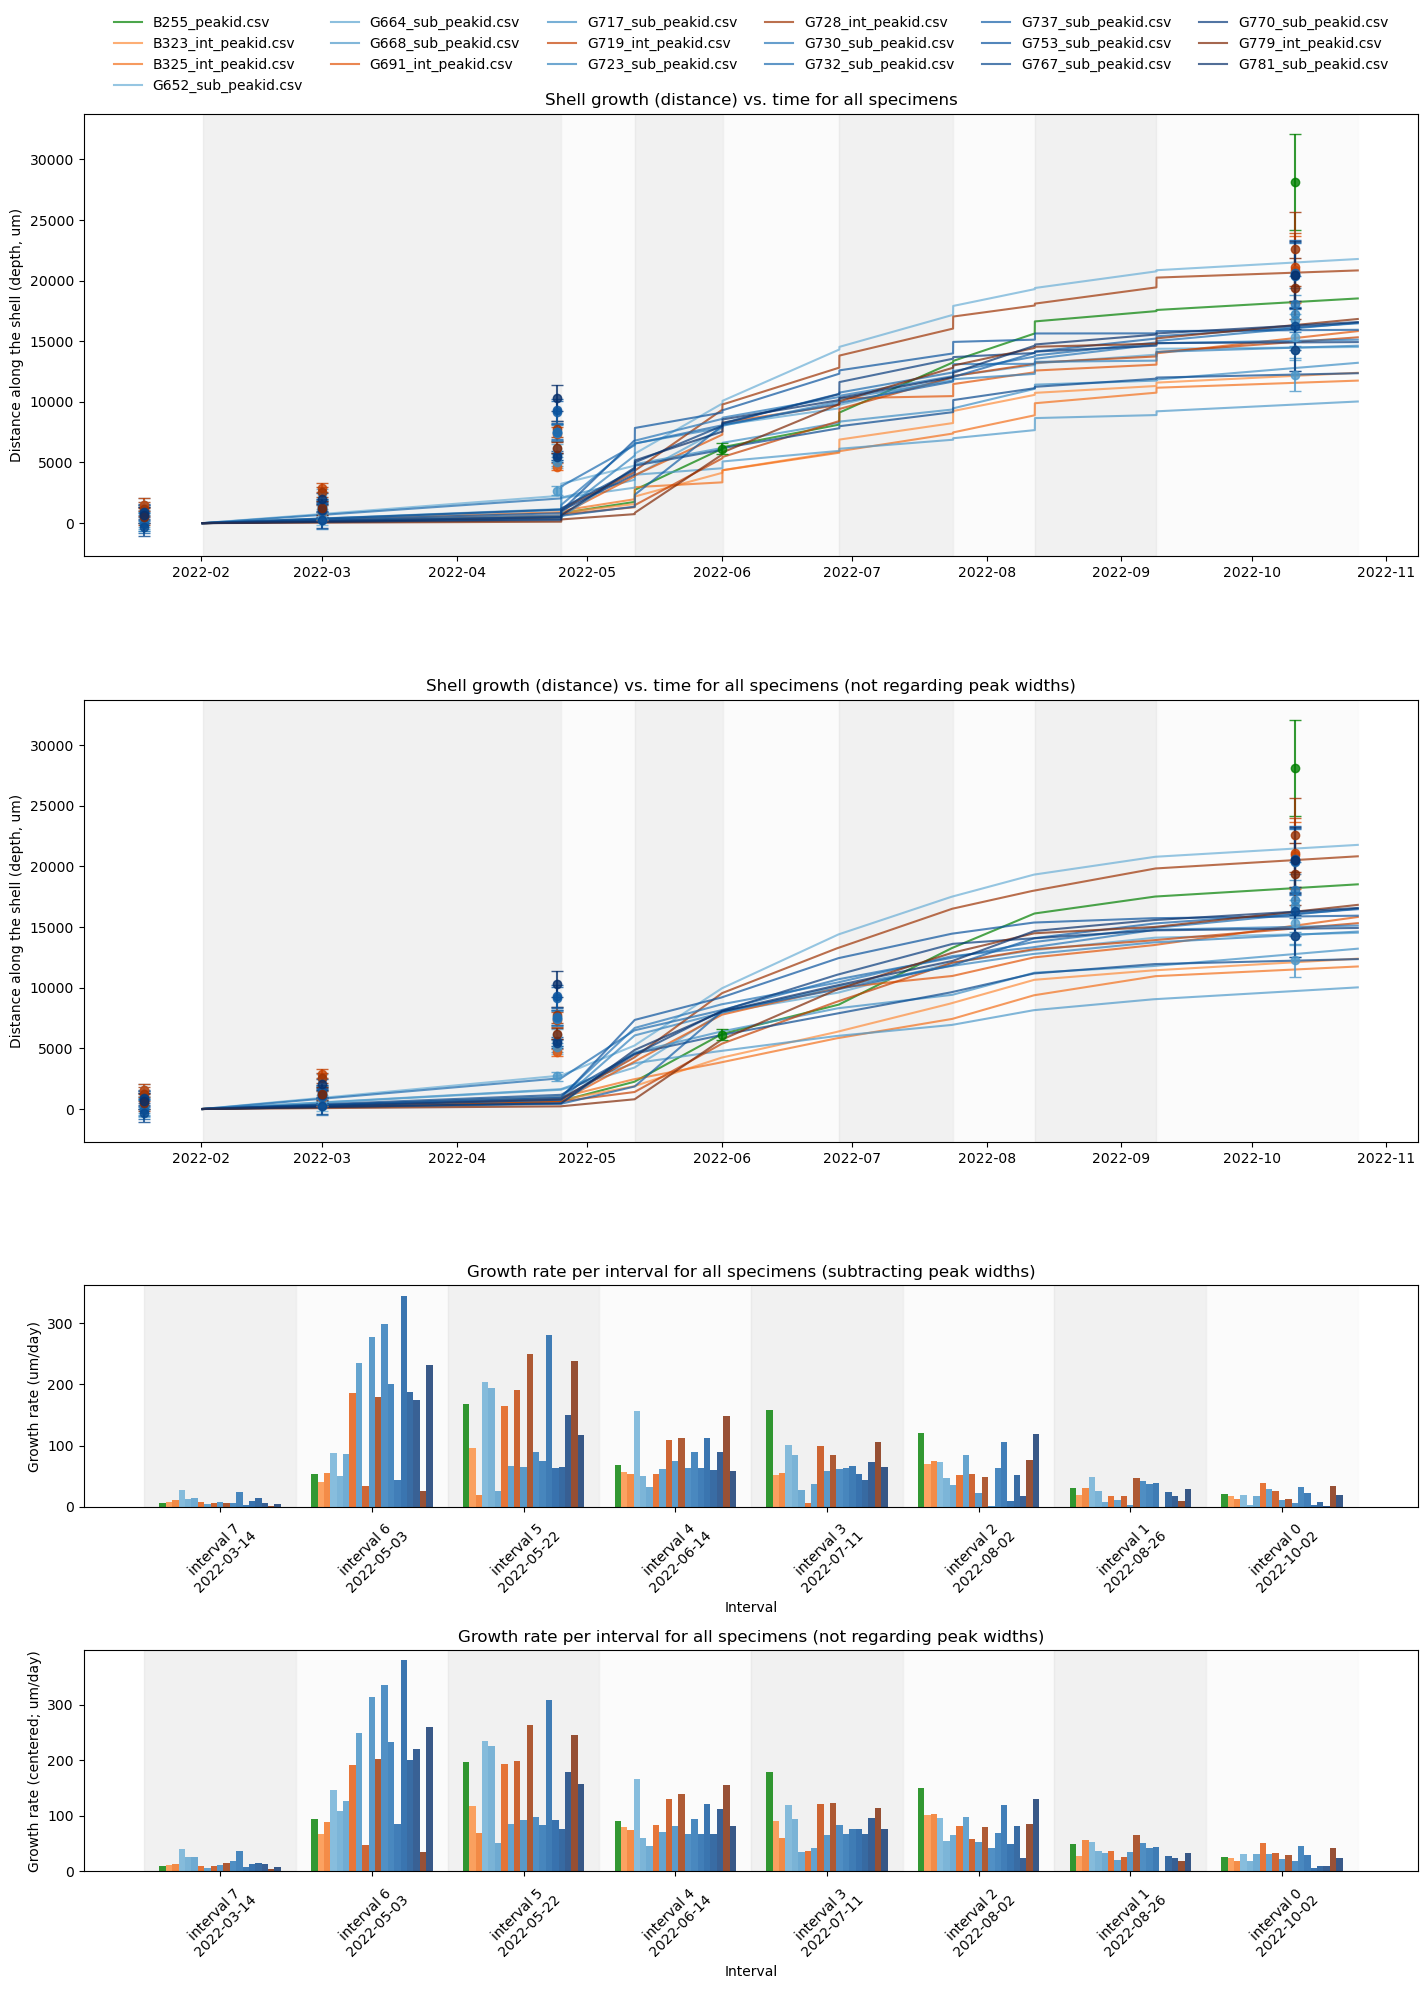

In [95]:
# Create a figure with two subplots: ax1 for shell growth (date x-axis), ax3 for growth rates (interval x-axis)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 20), sharex=False, gridspec_kw={'height_ratios': [2, 2, 1, 1]})

# Prepare color maps for subtidal and intertidal specimens
subtidal_files = [f for f in dataframes if 'sub' in f.lower()]
intertidal_files = [f for f in dataframes if 'int' in f.lower()]
subtidal_colors = cm.Blues(np.linspace(0.5, 1, len(subtidal_files)))
intertidal_colors = cm.Oranges(np.linspace(0.5, 1, len(intertidal_files)))

sub_idx = 0
inter_idx = 0

# For bar chart
bar_intervals = []
bar_rates = []
bar_colors = []
bar_specimens = []

# Line plot: shell growth vs. date
for file, df in dataframes.items():
    if 'depth' in df.columns and 'timing_info' in df.columns:
        df_plot = df.copy()
        df_plot['timing_info'] = pd.to_datetime(df_plot['timing_info'])
        df_plot['timing_info_centered'] = pd.to_datetime(df_plot['timing_info_centered'])
        df_plot['depth'] = df_plot['depth'].max() - df_plot['depth']
        if 'sub' in file.lower():
            color = subtidal_colors[sub_idx]
            sub_idx += 1
        elif 'int' in file.lower():
            color = intertidal_colors[inter_idx]
            inter_idx += 1
        else:
            color = 'green'
        ax1.plot(df_plot['timing_info'], df_plot['depth'], label=file, alpha=0.7, color=color) # Plotting depth against timing_info
        ax2.plot(df_plot['timing_info_centered'], df_plot['depth'], label=file, alpha=0.7, color=color) # Plotting depth against timing_info_centered

        # --- Add caliper long data (distance_mm_individual) with CI to the line plots ---
        for specimen_name in caliper_long['specimen'].unique():
            # Find files containing this specimen name
            matching_files = [f for f in dataframes if specimen_name in f]
            if file in matching_files:
                group = caliper_long[caliper_long['specimen'] == specimen_name]
                # Determine color and label for this specimen (same as line plot)
                if 'sub' in file.lower():
                    color = subtidal_colors[subtidal_files.index(file)]
                elif 'int' in file.lower():
                    color = intertidal_colors[intertidal_files.index(file)]
                else:
                    color = 'green'
                label = file  # Use the same label as in the line plot
                # Plot on ax1 (date x-axis)
                ax1.errorbar(
                    group['date'], group['distance_mm_individual'] * 1000,  # Convert to micrometers
                    yerr=group['distance_mm_ci_individual'] * 1000 if 'distance_mm_ci_individual' in group.columns else None,
                    fmt='o', capsize=4, label=label,
                    color=color, alpha=0.8, zorder=10
                )
                # Plot on ax2 (date x-axis, centered if available)
                ax2.errorbar(
                    group['date'], group['distance_mm_individual'] * 1000, # Convert to micrometers
                    yerr=group['distance_mm_ci_individual'] * 1000 if 'distance_mm_ci_individual' in group.columns else None,
                    fmt='o', capsize=4, label=label,
                    color=color, alpha=0.8, zorder=10
                )

        # Bar chart: growth rate per interval
        growths = growth_intervals.get(file, {})
        for interval_label, stats in growths.items():
            if stats['growth_rate'] is not None and not np.isnan(stats['growth_rate']):
                bar_intervals.append(int(interval_label.split()[-1]))
                bar_rates.append(stats['growth_rate'])
                bar_colors.append(color)
                bar_specimens.append(file)

# --- Prepare for grouped bar plot ---
unique_intervals = [f'interval {i}' for i in interval_numbers][::-1]
unique_specimens = list(labels)
n_intervals = len(unique_intervals)
n_specimens = len(unique_specimens)

# Build a matrix of growth rates: rows=intervals, cols=specimens
growth_rate_matrix = np.full((n_intervals, n_specimens), np.nan)
growth_rate_matrix_centered = np.full((n_intervals, n_specimens), np.nan)
bar_colors_matrix = np.empty((n_intervals, n_specimens), dtype=object)

for s_idx, specimen in enumerate(unique_specimens):
    growths = growth_intervals.get(specimen, {})
    for i_idx, interval in enumerate(unique_intervals):
        stats = growths.get(interval, None)
        if stats and stats['growth_rate'] is not None and not np.isnan(stats['growth_rate']):
            growth_rate_matrix[i_idx, s_idx] = stats['growth_rate']
            growth_rate_matrix_centered[i_idx, s_idx] = stats['growth_rate_centered']
            # Assign color as before
            if 'sub' in specimen.lower():
                color = subtidal_colors[subtidal_files.index(specimen)]
            elif 'int' in specimen.lower():
                color = intertidal_colors[intertidal_files.index(specimen)]
            else:
                color = 'green'
            bar_colors_matrix[i_idx, s_idx] = color
        else:
            bar_colors_matrix[i_idx, s_idx] = 'grey'

bar_width = 0.8 / n_specimens  # Make bars for each interval adjacent

# --- Plot grouped bars ---
for s_idx, specimen in enumerate(unique_specimens):
    x_positions = np.arange(n_intervals) + s_idx * bar_width - 0.4 + bar_width/2
    ax3.bar(
        x_positions,
        growth_rate_matrix[:, s_idx],
        width=bar_width,
        color=bar_colors_matrix[:, s_idx],
        alpha=0.8,
        label=specimen if s_idx == 0 else None  # Only label once for legend
    )
    ax4.bar(
        x_positions,
        growth_rate_matrix_centered[:, s_idx],
        width=bar_width,
        color=bar_colors_matrix[:, s_idx],
        alpha=0.8,
        label=specimen if s_idx == 0 else None  # Only label once for legend
    )

# Set x-ticks for intervals
ax3.set_xticks(np.arange(n_intervals))
ax4.set_xticks(np.arange(n_intervals))
# Add mean dates of intervals to x-tick labels
interval_labels_with_dates = []
for interval in unique_intervals:
    stats = interval_growths.get(interval, {})
    start = stats.get('start_date', None)
    end = stats.get('end_date', None)
    if start is not None and end is not None:
        mean_date = start + (end - start) / 2
        label = f"{interval}\n{mean_date.strftime('%Y-%m-%d')}"
    else:
        label = interval
    interval_labels_with_dates.append(label)

ax3.set_xticklabels(interval_labels_with_dates, rotation=45)
ax3.set_xlabel('Interval')
ax3.set_ylabel('Growth rate (um/day)')
ax3.set_title('Growth rate per interval for all specimens (subtracting peak widths)')
ax4.set_xticklabels(interval_labels_with_dates, rotation=45)
ax4.set_xlabel('Interval')
ax4.set_ylabel('Growth rate (centered; um/day)')
ax4.set_title('Growth rate per interval for all specimens (not regarding peak widths)')

# Format and legend for the shell growth plot
# Add shaded background boxes to delineate intervals on both plots
for i, interval in enumerate(unique_intervals):
    # Get start and end dates for the interval
    stats = interval_growths.get(interval, {})
    start = stats.get('start_date', None)
    end = stats.get('end_date', None)
    if start is not None and end is not None:
        # Alternate color for better visibility
        color = 'lightgrey' if i % 2 == 0 else 'whitesmoke'
        # Shade on ax1 (date x-axis)
        ax1.axvspan(start, end, color=color, alpha=0.3, zorder=0)
        # Shade on ax2 (date x-axis)
        ax2.axvspan(start, end, color=color, alpha=0.3, zorder=0)
        # Shade on ax3 (interval x-axis)
        ax3.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3, zorder=0)
        # Shade on ax4 (interval x-axis)
        ax4.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.3, zorder=0)
ax1.set_ylabel('Distance along the shell (depth, um)')
ax1.set_title('Shell growth (distance) vs. time for all specimens')
ax2.set_ylabel('Distance along the shell (depth, um)')
ax2.set_title('Shell growth (distance) vs. time for all specimens (not regarding peak widths)')
# Merge legend elements with the same name
handles, labels = ax1.get_legend_handles_labels()
unique = OrderedDict()
for h, l in zip(handles, labels):
    if l not in unique:
        unique[l] = h
ax1.legend(unique.values(), unique.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=6, frameon=False)
plt.tight_layout()
plt.show()

### Plot per specimen to scrutinize Sr spiking results on by one

In [96]:
output_dir = "Figures/Individual growth figures"
os.makedirs(output_dir, exist_ok=True)

for specimen in dataframes.keys():
    # specimen = next(iter(dataframes.keys())) # First specimen for testing
    df = dataframes[specimen]
    growths = growth_intervals[specimen]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot shell growth (distance along shell vs. time)
    df_plot = df.copy()
    df_plot['timing_info'] = pd.to_datetime(df_plot['timing_info'])
    df_plot['timing_info_centered'] = pd.to_datetime(df_plot['timing_info_centered'])
    df_plot['depth'] = df_plot['depth'].max() - df_plot['depth']
    ax1.plot(df_plot['timing_info'], df_plot['depth'], label='Shell growth', color='blue')
    ax1.plot(df_plot['timing_info_centered'], df_plot['depth'], label='Shell growth (ignoring peak widths)', color='lightblue') # FIXME
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Distance along shell (um)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Add caliper measurements (distance_mm_individual) with CI to the plots
    # Extract specimen name (e.g., 'B255' from 'B255_peakid.csv')
    match = re.match(r'([A-Z]\d{3})', specimen)
    if match:
        specimen_short = match.group(1)
        group = caliper_long[caliper_long['specimen'] == specimen_short]
        if not group.empty:
            # Plot on ax1 (distance along shell vs. date)
            ax1.errorbar(
                group['date'],
                group['distance_mm_individual'] * 1000,  # Convert mm to um
                yerr=group['distance_mm_ci_individual'] * 1000 if 'distance_mm_ci_individual' in group.columns else None,
                fmt='o', capsize=4, color='red', alpha=0.8, label='Caliper measurement (converted to distance along shell, um)'
            )

    # Plot growth rate as bars on a secondary y-axis
    ax2 = ax1.twinx()
    interval_labels = sorted(growths.keys(), key=lambda x: int(x.split()[-1]))
    growth_rates = [growths[label]['growth_rate'] for label in interval_labels]
    growth_rates_centered = [growths[label]['growth_rate_centered'] for label in interval_labels]
    interval_dates = [
        growths[label]['start_date'] + (growths[label]['end_date'] - growths[label]['start_date']) / 2
        if growths[label]['start_date'] is not None and growths[label]['end_date'] is not None else pd.NaT
        for label in interval_labels
    ]
    bar_width = 4  # days, half-width for each bar

    # Offset the bars so they are adjacent
    ax2.bar([d - pd.Timedelta(days=bar_width/2) for d in interval_dates], growth_rates, width=bar_width, alpha=0.6, color='orange', label='Growth rate (um/day)')
    ax2.bar([d + pd.Timedelta(days=bar_width/2) for d in interval_dates], growth_rates_centered, width=bar_width, alpha=0.6, color='green', label='Growth rate (ignoring peak widths; um/day)')
    ax2.set_ylabel('Growth rate (um/day)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    # Merge both legends into one
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

    fig.suptitle(f'Shell Growth and Growth Rate for {specimen}')
    fig.tight_layout()
    fig.savefig(os.path.join(output_dir, f"{specimen.replace('.csv','')}_growth.png"), dpi=300)
    plt.close(fig)

## Summarize trace element results per interval and export summary

In [111]:
# Collect summary statistics for all elemental columns in all dataframes, split by 'peak' and 'interval'
elemental_columns = [
    col for col in next(iter(dataframes.values())).columns
    if any(x in col for x in ['Ca', 'Na', 'Mg', 'Mn', 'Sr', 'Ba'])
]

summary_list = []

for file, df in dataframes.items():
    for category in ['peak', 'interval']:
        # Select rows where 'peak' column starts with the category name
        unique_categories = df['peak'].dropna().unique()
        for cat in unique_categories:
            if not cat.startswith(category):
                continue
            cat_rows = df[df['peak'] == cat]
            for elem in elemental_columns:
                if elem in cat_rows.columns:
                    values = cat_rows[elem].dropna()
                    N = values.count()
                    mean = values.mean()
                    std = values.std(ddof=1)
                    se = std / np.sqrt(N) if N > 0 else np.nan
                    cl95 = se * t.ppf(0.975, N-1) if N > 1 else np.nan

                    # Get start and end date from timing_info
                    timing_info = pd.to_datetime(cat_rows['timing_info'], errors='coerce')
                    start_date = timing_info.min() if not timing_info.isnull().all() else None
                    end_date = timing_info.max() if not timing_info.isnull().all() else None

                    # Get growth_rate_centered if available from growth_intervals (only for intervals)
                    growth_rate_centered = None
                    if cat.startswith('interval'):
                        growths = growth_intervals[file]  # Get growth intervals for the current file
                        if cat in growths and 'growth_rate_centered' in growths[cat]:
                            growth_rate_centered = growths[cat]['growth_rate_centered']

                    # Extract specimen name (e.g., 'B255' from 'B255_peakid.csv')
                    specimen_match = re.match(r'([A-Z]\d{3})', file)
                    specimen_name = specimen_match.group(1) if specimen_match else file

                    summary_list.append({
                        'specimen': specimen_name,
                        'category': cat,
                        'element': elem,
                        'mean': mean,
                        'std': std,
                        'se': se,
                        'cl95': cl95,
                        'N': N,
                        'growth_rate': growth_rate_centered,
                        'start_date': start_date,
                        'end_date': end_date
                    })

element_summary_df = pd.DataFrame(summary_list)
print(element_summary_df.head())
# Export the element summary dataframe to CSV
element_summary_df.to_csv("element_summary_by_peak_and_interval.csv", index=False)

  specimen category    element           mean           std           se  \
0     B255   peak 1       Ca43  416098.466128  46291.475506  3032.655393   
1     B255   peak 1  23Na/43Ca      22.945457      3.844426     0.251857   
2     B255   peak 1  25Mg/43Ca       0.913142      0.191774     0.012564   
3     B255   peak 1  43Ca/43Ca    1000.000000      0.000000     0.000000   
4     B255   peak 1  55Mn/43Ca       0.004705      0.000695     0.000046   

          cl95    N  growth_rate          start_date            end_date  
0  5975.064833  233          NaN 2022-09-09 01:40:00 2022-09-09 01:40:00  
1     0.496219  233          NaN 2022-09-09 01:40:00 2022-09-09 01:40:00  
2     0.024753  233          NaN 2022-09-09 01:40:00 2022-09-09 01:40:00  
3     0.000000  233          NaN 2022-09-09 01:40:00 2022-09-09 01:40:00  
4     0.000090  233          NaN 2022-09-09 01:40:00 2022-09-09 01:40:00  


### Example of a growth rate plot

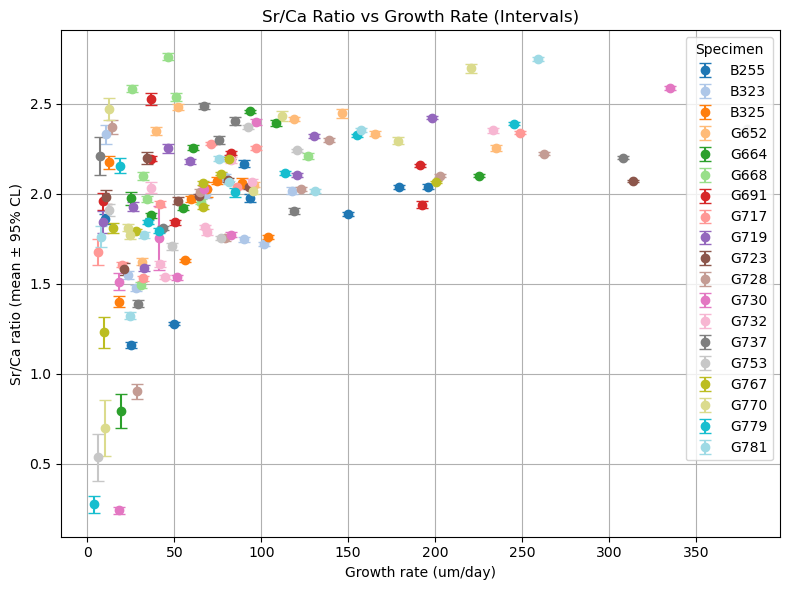

In [112]:
# Filter for interval rows and Sr/Ca ratios in the summary DataFrame
interval_sr = element_summary_df[
    (element_summary_df['category'].str.startswith('interval')) &
    (element_summary_df['element'] == '88Sr/43Ca')
].copy()

# Remove rows with missing growth_rate or mean
interval_sr = interval_sr.dropna(subset=['growth_rate', 'mean'])

# Assign a color to each specimen
specimens = interval_sr['specimen'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(specimens)))
color_map = dict(zip(specimens, colors))

plt.figure(figsize=(8, 6))
for specimen in specimens:
    data = interval_sr[interval_sr['specimen'] == specimen]
    plt.errorbar(
        data['growth_rate'],
        data['mean'],
        yerr=data['cl95'],
        fmt='o',
        ecolor=color_map[specimen],
        color=color_map[specimen],
        capsize=4,
        label=specimen
    )

plt.xlabel('Growth rate (um/day)')
plt.ylabel('Sr/Ca ratio (mean ± 95% CL)')
plt.title('Sr/Ca Ratio vs Growth Rate (Intervals)')
plt.grid(True)
plt.legend(title='Specimen')
plt.tight_layout()
plt.show()

# OUTLINE to do
* Import temperature, salinity and chlorophyl and segment into time intervals
* Combine data on shell chemistry, growth rate and environment into one dataset
* Try linear regressions between chemistry and environmental variables
    - Per specimen
    - Per treatment (sub vs intertidal)
* Try big multivariate regression / ANOVA
    - Dependent variables: Shell chemistry
    - Independent variables: Temperature, salinity, chlorophyl, growth rate, treatment (binary), species?
* Calculate effect sizes and reverse prediction